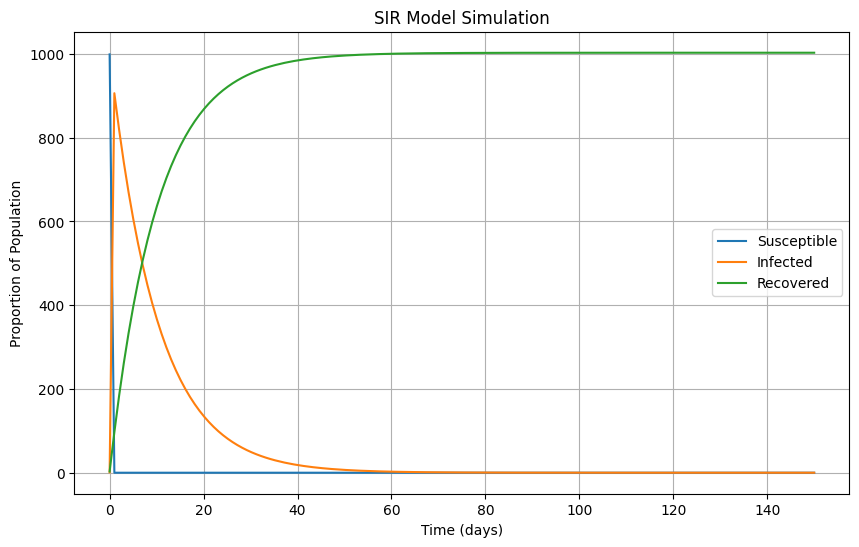

In [1]:
'''
Understand and implement the basic susceptible-infectious-recovered (SIR) compartmental model.
'''
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# SIR model equations
def SIR_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

S0 = 999  
I0 = 1  
R0 = 3  
y0 = [S0, I0, R0]

# Parameters
beta = 0.3  
gamma = 0.1  

# Time vector
t = np.linspace(0, 150, 150)  # Simulate for 150 days

# Solve the SIR model equations using odeint()
solution = odeint(SIR_model, y0, t, args=(beta, gamma))

# Extract results
S, I, R = solution.T

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population')
plt.title('SIR Model Simulation')
plt.legend()
plt.grid(True)
plt.show()

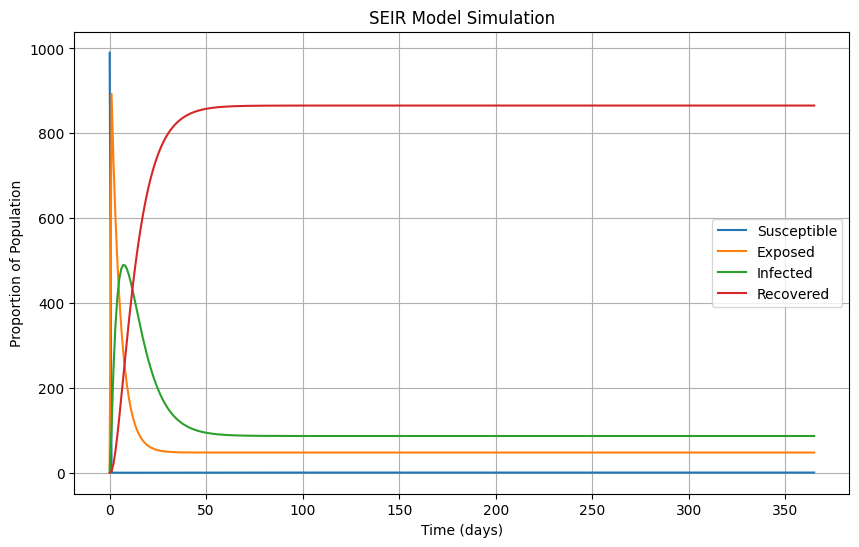

In [2]:
'''
SEIR Model with Births and Deaths
'''
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# SEIR model equations
def SEIR_model(y, t, beta, sigma, gamma, mu):
    S, E, I, R = y
    N = S + E + I + R
    dSdt = mu * N - beta * S * I - mu * S
    dEdt = beta * S * I - (sigma + mu) * E
    dIdt = sigma * E - (gamma + mu) * I
    dRdt = gamma * I - mu * R
    return [dSdt, dEdt, dIdt, dRdt]

# Initial conditions
S0 = 990  
E0 = 9  
I0 = 1  
R0 = 0  
y0 = [S0, E0, I0, R0]

# Parameters
beta = 0.3    
sigma = 0.2   
gamma = 0.1 
mu = 0.01
# Time vector
t = np.linspace(0, 365, 365)  

# Solve the SEIR model equations
solution = odeint(SEIR_model, y0, t, args=(beta, sigma, gamma, mu))

# Extract results
S, E, I, R = solution.T

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible')
plt.plot(t, E, label='Exposed')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population')
plt.title('SEIR Model Simulation')
plt.legend()
plt.grid(True)
plt.show()

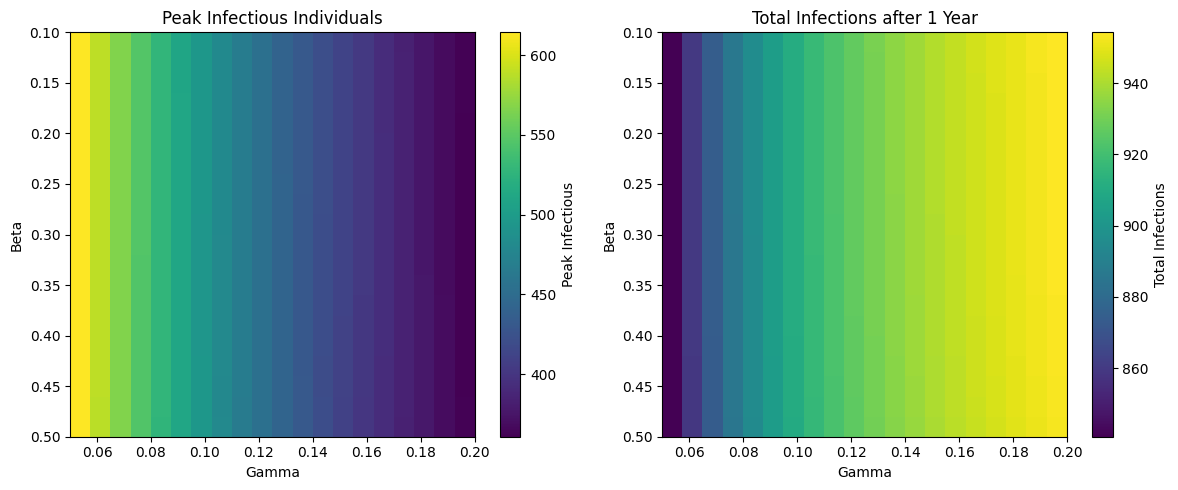

In [3]:
'''
Sensitivity Analysis
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# SEIR model equations
def SEIR_model(y, t, beta, sigma, gamma, mu):
    S, E, I, R = y
    N = S + E + I + R
    dSdt = mu * N - beta * S * I - mu * S
    dEdt = beta * S * I - (sigma + mu) * E
    dIdt = sigma * E - (gamma + mu) * I
    dRdt = gamma * I - mu * R
    return [dSdt, dEdt, dIdt, dRdt]

# Initial conditions
S0 = 990  
E0 = 9  
I0 = 1  
R0 = 0  
y0 = [S0, E0, I0, R0]

# Parameters   
sigma = 0.2   
mu = 0.01

# Define the parameter ranges
beta_range = np.linspace(0.1, 0.5, 20)
gamma_range = np.linspace(0.05, 0.2, 20)

# Initialize arrays to store results
peak_infectious = np.zeros((len(beta_range), len(gamma_range)))
total_infections = np.zeros((len(beta_range), len(gamma_range)))

# Time vector
t = np.linspace(0, 365, 365)

# Loop through parameter combinations
for i, beta in enumerate(beta_range):
    for j, gamma in enumerate(gamma_range):
        solution = odeint(SEIR_model, y0, t, args=(beta, sigma, gamma, mu))
        S, E, I, R = solution.T
        peak_infectious[i, j] = max(I)
        total_infections[i, j] = R[-1] + E[-1]

# Create heatmaps to visualize results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(peak_infectious, extent=[0.05, 0.2, 0.5, 0.1], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Peak Infectious')
plt.xlabel('Gamma')
plt.ylabel('Beta')
plt.title('Peak Infectious Individuals')

plt.subplot(1, 2, 2)
plt.imshow(total_infections, extent=[0.05, 0.2, 0.5, 0.1], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Total Infections')
plt.xlabel('Gamma')
plt.ylabel('Beta')
plt.title('Total Infections after 1 Year')

plt.tight_layout()
plt.show()

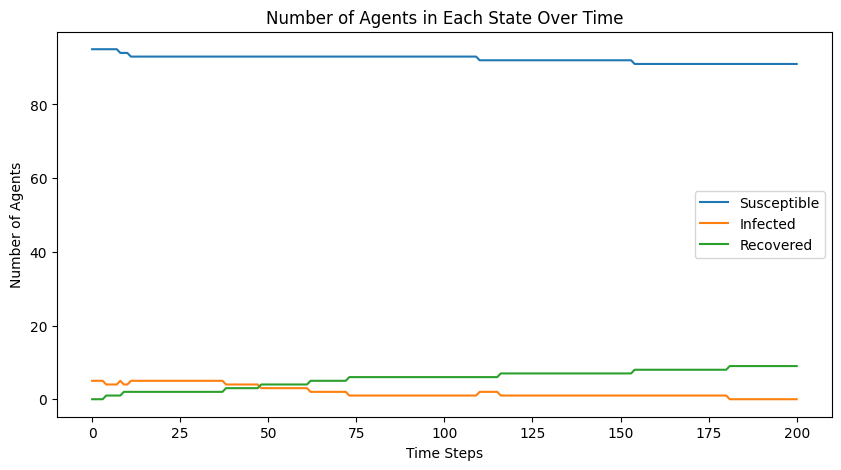

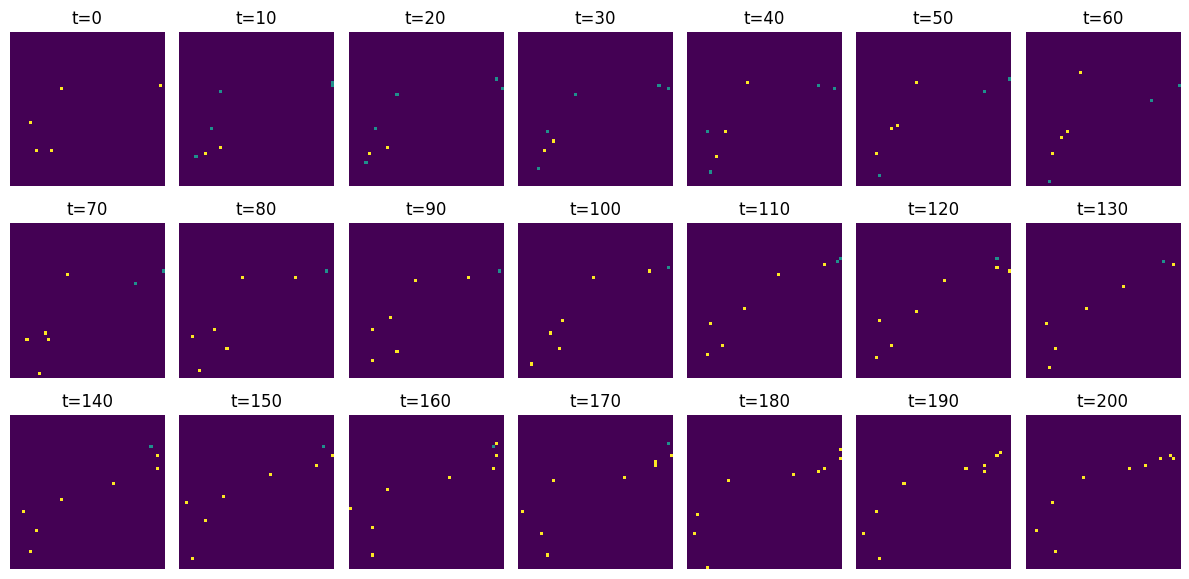

In [4]:
'''
Agent-Based Modeling of Pandemic Spread - regular movement
!pip install mesa
'''
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
import random
import matplotlib.pyplot as plt
import numpy as np

class InfectionModel(Model):
    def __init__(self, width, height, num_agents, initial_infected, p, q):
        self.num_agents = num_agents
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            if i < initial_infected:
                state = "I"
            else:
                state = "S"
            agent = Person(i, (x, y), self, state, p, q)
            self.grid.place_agent(agent, (x, y))
            self.schedule.add(agent)

        self.data = {"Susceptible": [], "Infected": [], "Recovered": []}

    def step(self):
        self.data["Susceptible"].append(sum(1 for agent in self.schedule.agents if agent.state == "S"))
        self.data["Infected"].append(sum(1 for agent in self.schedule.agents if agent.state == "I"))
        self.data["Recovered"].append(sum(1 for agent in self.schedule.agents if agent.state == "R"))

        self.schedule.step()

class Person(Agent):
    def __init__(self, unique_id, pos, model, state, p, q):
        super().__init__(unique_id, model)
        self.pos = pos
        self.state = state  # S: Susceptible, I: Infected, R: Recovered
        self.p = p
        self.q = q

    def move(self):
        x, y = self.pos
        dx, dy = random.choice([(0, 1), (0, -1), (1, 0), (-1, 0), (0, 0)])
        new_x, new_y = x + dx, y + dy
        new_x = max(0, min(new_x, self.model.grid.width - 1))
        new_y = max(0, min(new_y, self.model.grid.height - 1))
        self.model.grid.move_agent(self, (new_x, new_y))

    def transmit_infection(self):
        if self.state == "I":
            for neighbor in self.model.grid.get_neighbors(self.pos, moore=True, include_center=False):
                if neighbor.state == "S" and random.random() < self.p:
                    neighbor.state = "I"

    def recover(self):
        if self.state == "I" and random.random() < self.q:
            self.state = "R"

    def step(self):
        self.move()
        self.transmit_infection()
        self.recover()

def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "Color": "red" if agent.state == "I" else "green" if agent.state == "S" else "blue",
                 "r": 0.5}
    return portrayal

if __name__ == "__main__":
    width = 50
    height = 50
    num_agents = 100
    initial_infected = 5
    p = 0.05   # 0.05, 0.1
    q = 0.02   # 0.02, 0.05
    total_steps = 200
    snapshot_interval = 10
    model = InfectionModel(width, height, num_agents, initial_infected, p, q)

    snapshots = {}  # Dictionary to store grid snapshots at specific time steps
    for step in range(total_steps+1):
        model.step()

        if step % snapshot_interval == 0:
            grid_data = np.zeros((width, height))

            for agent in model.schedule.agents:
                x, y = agent.pos
                if agent.state == "I":
                    grid_data[x][y] = 1
                elif agent.state == "R":
                    grid_data[x][y] = 2

            snapshots[step] = grid_data.copy()

    # Plot the number of agents in each state over time
    data = model.data
    data_counts = [data["Susceptible"], data["Infected"], data["Recovered"]]
    data_counts = list(map(list, zip(*data_counts)))

    plt.figure(figsize=(10, 5))
    plt.plot(data_counts)
    plt.xlabel("Time Steps")
    plt.ylabel("Number of Agents")
    plt.legend(["Susceptible", "Infected", "Recovered"])
    plt.title("Number of Agents in Each State Over Time")
    plt.show()

    # Visualize the grid snapshots at specific time steps in a grid layout
    num_snapshots = len(snapshots)
    num_columns = 7
    num_rows = -(-num_snapshots // num_columns)  # Ceiling division to ensure all snapshots are displayed

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 2 * num_rows))

    for step, grid_data in snapshots.items():
        step_index = step//snapshot_interval
        ax = axes[step_index // num_columns, step_index % num_columns]
        im = ax.imshow(grid_data, cmap='viridis')
        ax.set_title(f"t={step}")
        ax.axis('off')

    for i in range(num_snapshots, num_rows * num_columns):
        axes[i // num_columns, i % num_columns].axis('off')

    plt.tight_layout()
    plt.show()

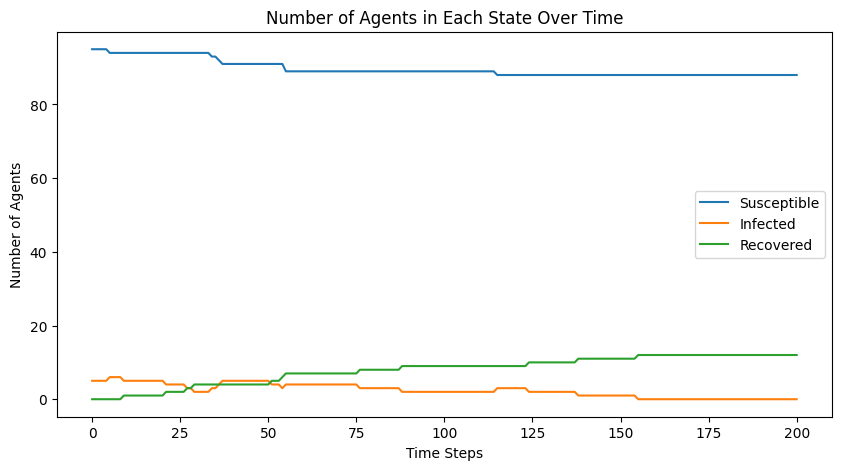

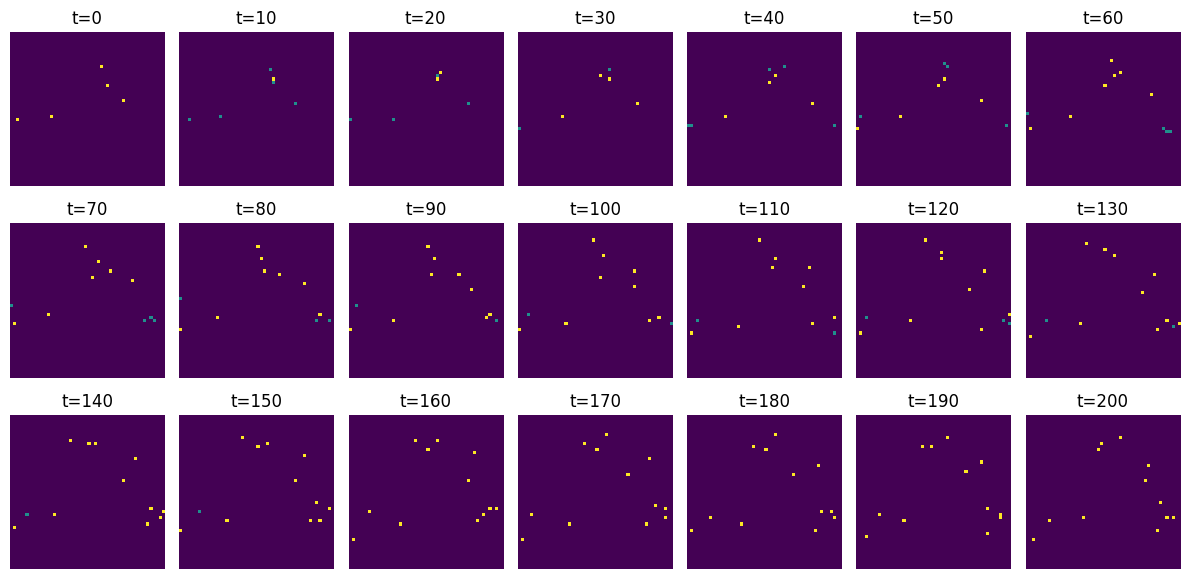

In [5]:
'''
Agent-Based Modeling of Pandemic Spread -  Social Distancing
!pip install mesa
'''
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
import random
import matplotlib.pyplot as plt
import numpy as np

class InfectionModel(Model):
    def __init__(self, width, height, num_agents, initial_infected, p, q, movement_probability):
        self.num_agents = num_agents
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.movement_probability = movement_probability
        # Create agents
        for i in range(self.num_agents):
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            if i < initial_infected:
                state = "I"
            else:
                state = "S"
            agent = Person(i, (x, y), self, state, p, q, self.movement_probability)
            self.grid.place_agent(agent, (x, y))
            self.schedule.add(agent)

        self.data = {"Susceptible": [], "Infected": [], "Recovered": []}

    def step(self):
        self.data["Susceptible"].append(sum(1 for agent in self.schedule.agents if agent.state == "S"))
        self.data["Infected"].append(sum(1 for agent in self.schedule.agents if agent.state == "I"))
        self.data["Recovered"].append(sum(1 for agent in self.schedule.agents if agent.state == "R"))

        self.schedule.step()

class Person(Agent):
    def __init__(self, unique_id, pos, model, state, p, q, movement_probability):
        super().__init__(unique_id, model)
        self.pos = pos
        self.state = state  # S: Susceptible, I: Infected, R: Recovered
        self.p = p
        self.q = q
        self.movement_probability = movement_probability

    def move(self):
        x, y = self.pos
        if random.random() < self.movement_probability:
            dx, dy = random.choice([(0, 1), (0, -1), (1, 0), (-1, 0), (0, 0)])
            new_x, new_y = x + dx, y + dy
            new_x = max(0, min(new_x, self.model.grid.width - 1))
            new_y = max(0, min(new_y, self.model.grid.height - 1))
        else:
            new_x = x
            new_y = y
        self.model.grid.move_agent(self, (new_x, new_y))

    def transmit_infection(self):
        if self.state == "I":
            for neighbor in self.model.grid.get_neighbors(self.pos, moore=True, include_center=False):
                if neighbor.state == "S" and random.random() < self.p:
                    neighbor.state = "I"

    def recover(self):
        if self.state == "I" and random.random() < self.q:
            self.state = "R"

    def step(self):
        self.move()
        self.transmit_infection()
        self.recover()

def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "Color": "red" if agent.state == "I" else "green" if agent.state == "S" else "blue",
                 "r": 0.5}
    return portrayal

if __name__ == "__main__":
    width = 50
    height = 50
    num_agents = 100
    initial_infected = 5
    p = 0.05   # 0.05, 0.1
    q = 0.02   # 0.02, 0.05
    total_steps = 200
    snapshot_interval = 10
    movement_probability = 0.5    # Add movement probability
    model = InfectionModel(width, height, num_agents, initial_infected, p, q, movement_probability)

    snapshots = {}  # Dictionary to store grid snapshots at specific time steps
    for step in range(total_steps+1):
        model.step()

        if step % snapshot_interval == 0:
            grid_data = np.zeros((width, height))

            for agent in model.schedule.agents:
                x, y = agent.pos
                if agent.state == "I":
                    grid_data[x][y] = 1
                elif agent.state == "R":
                    grid_data[x][y] = 2

            snapshots[step] = grid_data.copy()

    # Plot the number of agents in each state over time
    data = model.data
    data_counts = [data["Susceptible"], data["Infected"], data["Recovered"]]
    data_counts = list(map(list, zip(*data_counts)))

    plt.figure(figsize=(10, 5))
    plt.plot(data_counts)
    plt.xlabel("Time Steps")
    plt.ylabel("Number of Agents")
    plt.legend(["Susceptible", "Infected", "Recovered"])
    plt.title("Number of Agents in Each State Over Time")
    plt.show()

    # Visualize the grid snapshots at specific time steps in a grid layout
    num_snapshots = len(snapshots)
    num_columns = 7
    num_rows = -(-num_snapshots // num_columns)  # Ceiling division to ensure all snapshots are displayed

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 2 * num_rows))

    for step, grid_data in snapshots.items():
        step_index = step//snapshot_interval
        ax = axes[step_index // num_columns, step_index % num_columns]
        im = ax.imshow(grid_data, cmap='viridis')
        ax.set_title(f"t={step}")
        ax.axis('off')

    for i in range(num_snapshots, num_rows * num_columns):
        axes[i // num_columns, i % num_columns].axis('off')

    plt.tight_layout()
    plt.show()